In [0]:


#                              RESNET vs MOVILENET vs SIMPLE CNN


#***********************************IMPORTS*************************************

# Install TensorFlow
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
import numpy as np
from google.colab import drive
import sys
import os


drive.mount('/content/gdrive', force_remount=True)
project_path = "/content/gdrive/My Drive/shared/Colab Notebooks/tesi/models"           #PATH NEED TO BE CHANGED ACCORDING TO THE LOCATION OF THE PROJECT
data_path = "/content/gdrive/My Drive/shared/Colab Notebooks/tesi/data/"
weights_path = project_path + '/weights/'
sys.path.append(project_path)

from evaluation_utilities import *
from data_utilities import *
from net_utilities import *


#*******************************************************************************

In [0]:
#************************************PARAMS*************************************


n_classes = 345
batch_size = 128
random_seed = 1995
n_epoch = 1999
model =  'mobilenet' #['cnn', 'mobilenet', 'resnet']
dataset = 'quickdraw' # synth, quickdraw

if model == 'cnn':
  input_size = (28, 28, 1)
else:
  input_size = (32, 32, 3)



np.random.seed(seed=random_seed)
tf.random.set_seed(seed=random_seed)

#*******************************************************************************

In [0]:
#******************************DATA PROCESSING**********************************


print("loading data...")

_X = []
_y = []


# it loads some npy files
if dataset == "quickdraw":
  for cat in os.listdir(os.path.join(data_path, 'quickdraw_npy')):
    temp_data = np.load(os.path.join(data_path, 'quickdraw_npy', cat))
    _X.extend(temp_data)
    for it in range(len(temp_data)):
      _y.append(cat)
    print(cat, "loaded")

# it loads some pickle files
elif dataset == "synth":
  import pickle
  for cat in os.listdir(os.path.join(data_path, 'synth_04_pick')):
    with open(os.path.join(data_path, 'synth_04_pick', cat), 'rb') as pickle_file:
      temp_data_x, temp_data_y = pickle.load(pickle_file)
    _X.extend(temp_data_x)
    _y.extend(temp_data_y)    
    print(cat, "loaded")


_invert = False if dataset == "synth" else True
if model == "cnn":  
  X, y_string = load_data(data=[_X, _y], size=input_size[0], _3d=False, invert=_invert, randomize=False, rand_seed=random_seed)
#the resnet/mobilenet must loads the 28x28 (onebyte) images because of ram limit (generator then preprocess the data)
else:
  X, y_string = load_data(data=[_X, _y], size=input_size[0], _3d=True, invert=_invert, randomize=False, rand_seed=random_seed)
del _X, _y

#*******************************************************************************




In [0]:

x_train, x_valid, x_test, y_train, y_valid, y_test = split_dataset(X, y_string, _validation_size=0.2, _test_size=0.1, _random_seed=random_seed, stratify=True)

y_train, y_valid, y_test = labels_preprocessing(y_train, y_valid, y_test)

x_train, y_train = shuffle_with_same_indexes(x_train, y_train, seed=random_seed)
x_valid, y_valid = shuffle_with_same_indexes(x_valid, y_valid, seed=random_seed)
x_test, y_test = shuffle_with_same_indexes(x_test, y_test, seed=random_seed)

del X, y_string

assert len(set(y_train)) == n_classes, print("wrong class number")

print("data loaded")

created: x_train:  (993600, 32, 32, 3)
created: x_valid:  (248400, 32, 32, 3)
created: x_test:  (138000, 32, 32, 3)
created: y_string_train:  (993600,)
created: y_string_valid:  (248400,)
created: y_string_test:  (138000,)
created: num classes:  345 345 345
data loaded


In [0]:

is_data_already_prepro = False if np.max(x_train[0]) > 1 else True
print("is data preprocessed? ", is_data_already_prepro)

custom_aug = CustomAug({
      'rescale': not is_data_already_prepro,        # if rescale == True, the alg assumes the data is in format 0-255
      'pad' : True,                           
      'horizontal_flip' : True,             
      'erosion' : True,                       
      'half_aug' : True,
    }
)


datagen = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=custom_aug.custom_preprocessing)
train_gen = datagen.flow(x_train, y_train, batch_size=batch_size)
valid_gen = datagen.flow(x_valid, y_valid, batch_size=batch_size)


is data preprocessed?  False


0.007843138 1.0 (32, 32, 3)


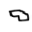

0.015686275 1.0 (32, 32, 3)


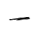

0.0 1.0 (32, 32, 3)


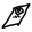

0.015686275 1.0 (32, 32, 3)


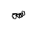

0.0 1.0 (32, 32, 3)


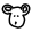

0.0 1.0 (32, 32, 3)


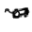

0.0 1.0 (32, 32, 3)


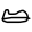

0.0 1.0 (32, 32, 3)


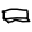

0.0 1.0 (32, 32, 3)


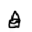

0.043137256 1.0 (32, 32, 3)


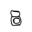

0.0 1.0 (32, 32, 3)


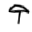

0.0 1.0 (32, 32, 3)


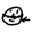

0.0 1.0 (32, 32, 3)


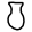

0.0 1.0 (32, 32, 3)


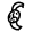

0.0 1.0 (32, 32, 3)


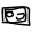

In [0]:
for i, im in enumerate(x_train):
  if i < 15:
    mm = custom_aug.custom_preprocessing(im)
    #print(np.asarray(mm))
    print(np.min(np.asarray(mm)), np.max(np.asarray(mm)), np.asarray(mm).shape)
    show_img(mm)

In [0]:
class SimpleEmbeddingNet(tf.keras.Model):

  def __init__(self):
    self.filter_size = 24
    self.first_kernel_size = 3
    self.embedding_size = 256

    super(SimpleEmbeddingNet, self).__init__()

    self.l1_conv    = tf.keras.layers.Conv2D(self.filter_size,kernel_size=self.first_kernel_size,activation='relu',input_shape=(28,28,1))
    self.l1_batch   = tf.keras.layers.BatchNormalization()
    self.l2_conv    = tf.keras.layers.Conv2D(self.filter_size,kernel_size=3,activation='relu')
    self.l2_batch   = tf.keras.layers.BatchNormalization()
    self.l3_conv    = tf.keras.layers.Conv2D(self.filter_size,kernel_size=5,strides=2,padding='same',activation='relu')
    self.l3_batch   = tf.keras.layers.BatchNormalization()
    self.l3_dropout = tf.keras.layers.Dropout(0.4)
    self.l4_conv    = tf.keras.layers.Conv2D(self.filter_size*2,kernel_size=3,activation='relu')
    self.l4_batch   = tf.keras.layers.BatchNormalization()
    self.l5_conv    = tf.keras.layers.Conv2D(self.filter_size*2,kernel_size=3,activation='relu')
    self.l5_batch   = tf.keras.layers.BatchNormalization()
    self.l6_conv    = tf.keras.layers.Conv2D(self.filter_size*2,kernel_size=5,strides=2,padding='same',activation='relu')
    self.l6_batch   = tf.keras.layers.BatchNormalization()
    self.l6_dropout = tf.keras.layers.Dropout(0.4)
    self.l7_flatten = tf.keras.layers.Flatten()
    self.l7_dense   = tf.keras.layers.Dense(self.embedding_size, activation='relu')

  
  def call(self, x):
    x = self.l1_conv(x)
    x = self.l1_batch(x)
    x = self.l2_conv(x)
    x = self.l2_batch(x)
    x = self.l3_conv(x)
    x = self.l3_batch(x)
    x = self.l3_dropout(x)
    x = self.l4_conv(x)
    x = self.l4_batch(x)
    x = self.l5_conv(x)
    x = self.l5_batch(x)
    x = self.l6_conv(x)
    x = self.l6_batch(x)
    x = self.l6_dropout(x)
    x = self.l7_flatten(x)
    x = self.l7_dense(x)   

    return x


class SimpleNet(tf.keras.Model):

  def __init__(self, n_classes=10):
    super(SimpleNet, self).__init__()

    self.embedding_net = SimpleEmbeddingNet()

    self.l7_batch   = tf.keras.layers.BatchNormalization()
    self.l7_dropout = tf.keras.layers.Dropout(0.4)
    self.l8_dense   = tf.keras.layers.Dense(n_classes, activation='softmax')

  def call(self, x):
    
    x = self.embedding_net.call(x) 

    x = self.l7_batch(x)
    x = self.l7_dropout(x)
    x = self.l8_dense(x)

    return x




class ResNet(tf.keras.Model):

  def __init__(self, n_classes=10):
    super(ResNet, self).__init__()

    self.resnet = tf.keras.applications.ResNet50(input_tensor=tf.keras.layers.Input(shape=(32, 32, 3)), input_shape=input_size, include_top = False, pooling = 'avg', weights=None)

    self.lastL1   = tf.keras.layers.BatchNormalization()
    self.lastL2   = tf.keras.layers.Dropout(0.4)
    self.lastL3   = tf.keras.layers.Dense(n_classes, activation='softmax')

  def call(self, x):

    x = self.resnet(x)
    x = self.lastL1(x)
    x = self.lastL2(x)
    x = self.lastL3(x)

    return x



class MobileNet(tf.keras.Model):

  def __init__(self, n_classes=10):
    super(MobileNet, self).__init__()

    self.mobilenet = tf.keras.applications.mobilenet.MobileNet(
        input_tensor=tf.keras.layers.Input(shape=(32, 32, 3)),
        input_shape=(input_size), 
        alpha=1.0, 
        include_top=False, 
        weights=None, 
        pooling='avg', 
        classes=None
    )

    self.lastL1   = tf.keras.layers.BatchNormalization()
    self.lastL2   = tf.keras.layers.Dropout(0.4)
    self.lastL3   = tf.keras.layers.Dense(n_classes, activation='softmax')


  def call(self, x):

    x = self.mobilenet(x)
    x = self.lastL1(x)
    x = self.lastL2(x)
    x = self.lastL3(x)

    return x



#*********************************************************************************************************************************************
net_callbacks = [
	PlotLosses(),
  tf.keras.callbacks.ModelCheckpoint(weights_path +  model + "_" +  dataset + "{epoch:02d}"  + '.h5',  monitor='val_acc', verbose=1, period=5, save_best_only=True, mode='max'),
	#tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, min_delta=1, verbose=1, mode='auto', restore_best_weights=True)
]
print("net_callbacks var created")
#*********************************************************************************************************************************************

lr =  0.0001


if model == 'resnet':
  resnet = ResNet(n_classes=n_classes)
  resnet.compile(tf.keras.optimizers.Adam(lr), loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=['acc'])
  resnet.build((batch_size, input_size[0], input_size[1], input_size[2]))

elif model == 'mobilenet':
  mobilenet = MobileNet(n_classes=n_classes)
  mobilenet.compile(tf.keras.optimizers.Adam(lr), loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=['acc'])
  mobilenet.build((batch_size, input_size[0], input_size[1], input_size[2]))

elif model == 'cnn':
  simple_net = SimpleNet(n_classes=n_classes)
  simple_net.compile(tf.keras.optimizers.Adam(lr), loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=['acc'])
  simple_net.build((batch_size, input_size[0], input_size[1], input_size[2]))


In [0]:
#***********************************NETWORK*************************************


if model == 'resnet':
  res_history = resnet.fit(
      train_gen,
      epochs=n_epoch, 
      verbose=2, 
      callbacks=net_callbacks,  
      validation_data=valid_gen,
  )

elif model == 'mobilenet':
  mobile_history = mobilenet.fit(
      train_gen,
      epochs=n_epoch, 
      verbose=2, 
      callbacks=net_callbacks,  
      validation_data=valid_gen,
  )

elif model == 'cnn':
  simple_history = simple_net.fit(
      train_gen,
      epochs=n_epoch, 
      verbose=2, 
      callbacks=net_callbacks,  
      validation_data=valid_gen, 
  )

#*******************************************************************************

In [0]:

''' test set must be preprocessed like the training and valid generator data '''
if np.max(x_test) > 1:
    x_test = data_preprocessing(x_test)

if model == "resnet":
  resnet.load_weights(weights_path + 'resnet_synth_quickdraw10.h5')

  print(resnet.evaluate(x_test, y_test))
  embedding_net = resnet.resnet

elif model == "mobilenet":
  mobilenet.load_weights(weights_path + 'mobilenet_quickdraw20.h5')    

  print(mobilenet.evaluate(x_test, y_test))
  embedding_net = mobilenet.mobilenet


elif model == "cnn":
  simple_net.load_weights(weights_path + 'cnn_256_quickdraw15.h5')    

  print(simple_net.evaluate(x_test, y_test))
  embedding_net = simple_net.embedding_net



In [0]:
if model == "cnn":
  X_icons_eval = load_data(path=data_path + "/icons_eval.pickle", size=input_size[0], invert=False, _3d=False, randomize=False, rand_seed=random_seed)
else:
  X_icons_eval = load_data(path=data_path + "/icons_eval.pickle", size=input_size[0], invert=False, _3d=True, randomize=False, rand_seed=random_seed)

# delete white images
X_icons_eval = np.asarray([i for i in X_icons_eval if np.min(i) != np.max(i)])

X_icons_eval_edges = data_preprocessing(X_icons_eval)

for _i, i in enumerate(X_icons_eval_edges): X_icons_eval_edges[_i] = contour_img(i)

for i, im in enumerate(X_icons_eval_edges):
  if i < 10:
    show_img(im)

In [0]:
manual_eval = RankImages(X_icons_eval_edges, embedding_net, _n=15, _show_im=False, _show_dist=False)


In [0]:

#target_im = paint_brush_img(w=input_size[0], h=input_size[1], line_width=30, preprocessed=True, show=False)
images = [cv2.imread(os.path.join(data_path, 'targets', im_path), 0) for im_path in os.listdir(os.path.join(data_path, 'targets')) if im_path.endswith('.jpg')]
images = [cv2.resize(i, (input_size[0], input_size[1])) for i in images]

for image in images:
  target_im = image

  if model == 'cnn': 
      target_im = np.expand_dims(data_preprocessing(target_im), axis=-1)
  else:
      target_im = cv2.cvtColor(target_im, cv2.COLOR_GRAY2RGB)

  # a or b
  #target_im_edges = data_preprocessing(target_im)  # a
  target_im_edges = contour_img(target_im)          # b

  res = manual_eval.get_n_most_similar_images(target_im_edges, _returnType='indexes')
  manual_eval.format_result(target_im, [X_icons_eval_edges[r] for r in res])

In [0]:
target_im = paint_brush_img(w=input_size[0], h=input_size[1], line_width=30, preprocessed=True, show=False)

if model == 'resnet': 
  target_im = cv2.cvtColor(target_im, cv2.COLOR_GRAY2RGB)

target_im_edges = contour_img(target_im)

res = manual_eval.get_n_most_similar_images(target_im_edges, _returnType='indexes')
manual_eval.format_result(target_im, [X_icons_eval[r] for r in res])

In [0]:

#***********************************FROM PYTHON MODEL TO JS MODEL*************************************

#!pip install tensorflowjs

# PRETRAINING MOBILENET_V1 MODEL
#mobilenet = MobileNet(n_classes=345)
#mobilenet.compile(tf.keras.optimizers.Adam(lr), loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=['acc'])
#mobilenet.build((batch_size, input_size[0], input_size[1], input_size[2]))
#mobilenet.load_weights(weights_path + "official/mobilenet_quickdraw_v1_20.h5")

#mobilenet.mobilenet.save(weights_path + "models/mobilenet_quickdraw_v1_20.h5")


# FINETUNED MOBILENET_V1 MODEL (MIXED MODE)

#mobilenet = MobileNet(n_classes=169)
#mobilenet.compile(tf.keras.optimizers.Adam(lr), loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=['acc'])
#mobilenet.build((batch_size, input_size[0], input_size[1], input_size[2]))
#mobilenet.load_weights(weights_path + "official/mixed_mobilenet_mobilenet_quickdraw_v1_10.h5")

#mobilenet.mobilenet.save(weights_path + "models/mixed_mobilenet_mobilenet_quickdraw_v1_10.h5")


#!tensorflowjs_converter --input_format keras "./models/mixed_mobilenet_mobilenet_quickdraw_v1_10.h5" "./models/mixed_mobilenet_mobilenet_quickdraw_v1_10_js.h5"